In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [32]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap
import itertools
import random
inf = float("inf")

In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [4]:
from IPython.display import IFrame
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

In [9]:
from schlichtanders.myobjects import NestedNamespace

# target

In [65]:
input = tm.as_tensor_variable([1,2])
pol = tm.Model(inputs=[input], outputs=T.sum(input ** (T.arange(input.size)+1)))
noisy_pol = pm.GaussianNoise(pol, init_var=0.5)
data_target = tm.Merge(noisy_pol, pol)
data_target

Merge39 { 'inputs': [TensorConstant{[ 1.  2.]}],
  'outputs': GaussianNoise15.outputs,
  'parameters': [],
  'parameters_positive': [var]}

In [66]:
param_target = pm.DiagGauss(init_mean=[-2,-3], init_var=[2,5])

In [67]:
data_target['inputs'] = [param_target]
target = tm.Merge(data_target, param_target)
target

Merge41 { 'inputs': [],
  'outputs': GaussianNoise15.outputs,
  'parameters': [mean],
  'parameters_positive': [var, var]}

In [68]:
sampler = target.function()

<IPython.core.display.Javascript object>


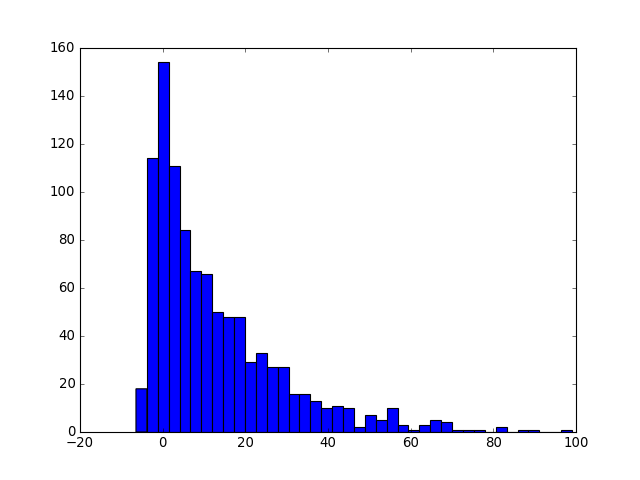

(array([  18.,  114.,  154.,  111.,   84.,   67.,   66.,   50.,   48.,
          48.,   29.,   33.,   27.,   27.,   16.,   16.,   13.,   10.,
          11.,   10.,    2.,    7.,    5.,   10.,    3.,    1.,    3.,
           5.,    4.,    1.,    1.,    1.,    0.,    2.,    0.,    1.,
           1.,    0.,    0.,    1.]),
 array([ -6.45975897,  -3.82242538,  -1.1850918 ,   1.45224179,
          4.08957537,   6.72690896,   9.36424255,  12.00157613,
         14.63890972,  17.2762433 ,  19.91357689,  22.55091047,
         25.18824406,  27.82557764,  30.46291123,  33.10024481,
         35.7375784 ,  38.37491198,  41.01224557,  43.64957915,
         46.28691274,  48.92424632,  51.56157991,  54.19891349,
         56.83624708,  59.47358066,  62.11091425,  64.74824783,
         67.38558142,  70.02291501,  72.66024859,  75.29758218,
         77.93491576,  80.57224935,  83.20958293,  85.84691652,
         88.4842501 ,  91.12158369,  93.75891727,  96.39625086,  99.03358444]),
 <a list of 40 Patch o

In [69]:
plt.hist(np.array([sampler() for _ in range(1000)]), bins=40)

In [16]:
mlp = dm.Mlp(input=input, hidden_sizes=[6], hidden_transfers=['rectifier'], output_size=1, output_transfer="identity")
mlp

Mlp3 { 'inputs': [TensorConstant{[ 1.  2.  3.  4.]}],
  'outputs': AffineNonlinear6.outputs,
  'parameters': [weights5, bias5, weights6, bias6]}

In [17]:
noisy_mlp = pm.GaussianNoise(mlp, init_var=[2,5])
noisy_mlp

GaussianNoise3 { 'inputs': [AffineNonlinear6.outputs],
  'outputs': GaussianNoise3.outputs,
  'parameters': [],
  'parameters_positive': [var]}

In [18]:
mlp_flat = tm.Flatten(mlp['parameters'])
mlp_flat

Flatten3 { 'flat': "weights5:bias5:weights6:bias6",
  'inputs': [],
  'outputs': [weights5_flat, bias5_flat, weights6_flat, bias6_flat]}

In [ ]:
mlp_flat['flat'] = mlp_flat['flat']

# Model

## data modelling

In [10]:
data_model = pm.Categorical(3)
data_model = Merge(data_model, Reparameterize(data_model['parameters_psumto1'], softmax, softmax_inv))
data_model

Merge { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fb502655d00 for function at 0x7fb50253ede8>,
  'outputs': Categorical.outputs,
  'parameters': [TensorConstant{(3,) of 0...3333333333}_softmax],
  'parameters_psumto1': []}

## parameter modelling

In [11]:
params_model = pm.Gauss(3)
# if you want to use size directly, CAUTION, you need to copy before!
# params_base.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
params_model

Gauss { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fb502565980 for function at 0x7fb5025020c8>,
  'noise': [GaussianNoise.noise.0],
  'outputs': GaussianNoise.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

## bayes

In [12]:
prior_model = pm.Gauss(3, init_var=np.exp(-6))
# label hyper parameters accordingly
prior_model = Merge(prior_model,
              parameters=None, # mean is not adapted at all, but left centred at zero
              parameters_positive='hyperparameters_positive')
prior_model

Merge2 { 'hyperparameters_positive': [var2],
  'inputs': [],
  'logP': <FunctionWrapper at 0x7fb5025658a0 for function at 0x7fb502502758>,
  'noise': [GaussianNoise2.noise.0],
  'outputs': GaussianNoise2.outputs,
  'parameters': []}

In [13]:
model = variational_bayes(data_model, 'parameters', params_model, priors=prior_model)
model

variational_lower_bound { 'hyperparameters_positive': [var2],
  'inputs': [],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7fb502526e50 for function at 0x7fb502502e60>,
  'loglikelihood': <FunctionWrapper at 0x7fb502655d00 for function at 0x7fb50253ede8>,
  'n_data': n_data,
  'noise': [GaussianNoise.noise.0, GaussianNoise2.noise.0],
  'outputs': Categorical.outputs,
  'parameters': [mean],
  'parameters_positive': [var],
  'parameters_psumto1': []}

In [14]:
# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
model = Merge(model, Reparameterize(model['parameters_positive'], softplus, softplus_inv))
model = Merge(model, Flatten(model['parameters']))
model

Merge4 { 'flat': "mean:var_softplus",
  'hyperparameters_positive': [var2],
  'inputs': [],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7fb502526e50 for function at 0x7fb502502e60>,
  'loglikelihood': <FunctionWrapper at 0x7fb502655d00 for function at 0x7fb50253ede8>,
  'n_data': n_data,
  'noise': [GaussianNoise.noise.0, GaussianNoise2.noise.0],
  'outputs': Categorical.outputs,
  'parameters': [],
  'parameters_positive': [],
  'parameters_psumto1': []}

# Target

In [15]:
data_target = pm.Categorical(3)
data_target = Merge(data_target, Reparameterize(data_target['parameters_psumto1'], softmax, softmax_inv))
data_target

params_target = pm.Gauss(init_mean=[1,3,2], init_var=4)
prior_target = pm.Gauss(3, init_var=np.exp(-6))
target = variational_bayes(data_target, 'parameters', params_target, priors=prior_target)
f_target = target.function()
targets = np.array([f_target() for _ in range(10000)])
validation = np.array([f_target() for _ in range(1000)])
targets[:10]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

# Optimizer

In [16]:
# dm.InvertibleModel.INVERTIBLE_MODELS
reduce_all_identities()
# dm.InvertibleModel.INVERTIBLE_MODELS

Climin wants an iterator of (args, kwarsg) as keyword argument "args" (to be passed to the loss function). Concretley, we use an infinite iterator over minibatches.

In [79]:
batch_size = 31
n_batches = len(targets) // batch_size  # after this many steps we went through the whole data set once

climin_args = izip(imap(lambda x:(x,), chunk(batch_size, cycle(targets))), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)

def weights_data():
    for t in itertools.count():
        yield min(1, 0.01 + t/n_batches*20) # n_batches has an epoch, hence 20 epochs
        
assert len(list(weights_regularizer_1epoch())) == n_batches

In [110]:
mapreduce = summap
average_n = 1
if average_n > 1:
    mapreduce = compose_fmap(mapreduce, Average(average_n))
    # mind the order!!! as currently the chunks are iterators only, we cannot first summap and then Average, 
    # as this would imply iterating over the same 

postmap = compose(post.flat_numericalize_postmap, post.variational_postmap) 
postmap_kwargs = {
    'mapreduce': mapreduce,  # TODO add more functionality for composed fmaps, with args
    'annealing_combiner': post.AnnealingCombiner(
        weights_regularizer=cycle(weights_regularizer_1epoch())
#         weights_data=weights_data()
    ),
    'adapt_init_params': lambda ps: ps + np.random.normal(size=ps.size, scale=0.1),
#     'profile': True,
    'mode': 'FAST_RUN'
}
optimizer_kwargs = postmap(model, **postmap_kwargs)
climin_kwargs = post.climin_postmap(optimizer_kwargs)
climin_kwargs

{'f': <function theano_models.postmaps.annealed>,
 'fprime': <function theano_models.postmaps.annealed>,
 'wrt': array([ 0.02437438,  0.00054978, -0.05261473,  0.40367996])}

In [111]:
opt = optimizer(
    identifier="adam",
#     identifier="rmsprop",
    step_rate=1e-4,  # 1e-6 is too small it seems
#     momentum=0.9,
    args=climin_args,
    **climin_kwargs
)

# Visualized Fit

<IPython.core.display.Javascript object>


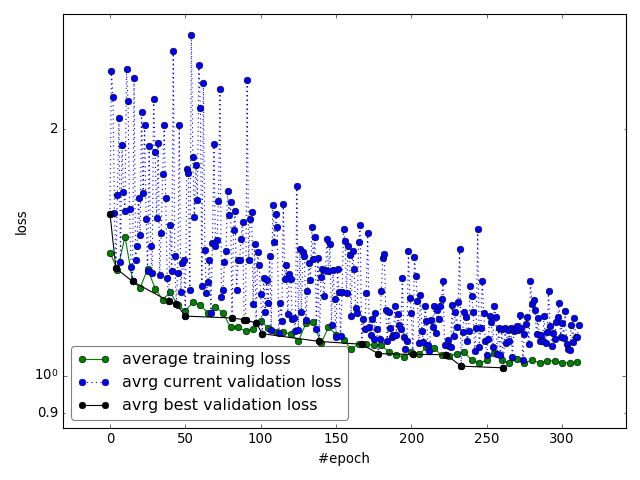

In [112]:
# plot: 
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("loss")
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

# start values:
best_parameters = optimizer_kwargs['num_parameters']
best_val_loss = optimizer_kwargs['num_loss'](best_parameters, validation, no_annealing=True)
# best_val_loss /= len(validation)
training_loss = optimizer_kwargs['num_loss'](best_parameters, targets, no_annealing=True)
# training_loss /= len(targets)
last_improvement_epoch = opt.n_iter//n_batches

add_point(line_best_val, last_improvement_epoch, best_val_loss)
add_point(line_curr_val, last_improvement_epoch, best_val_loss)
add_point(line_train, last_improvement_epoch, training_loss)

In [113]:
for info in every(n_batches, opt):
    current_epoch = info['n_iter']//n_batches
    if current_epoch - last_improvement_epoch > 50:
        break
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, validation, no_annealing=True)
#     val_loss /= len(validation)
    if val_loss < best_val_loss:
        last_improvement_epoch = current_epoch
        best_parameters = opt.wrt
        best_val_loss = val_loss
        add_point(line_best_val, current_epoch, val_loss)
    add_point(line_curr_val, current_epoch, val_loss)
    
    # visualize training loss for comparison:
    if current_epoch%5 == 0:
        training_loss = optimizer_kwargs['num_loss'](opt.wrt, targets, no_annealing=True)
#         training_loss /= len(targets)
        add_point(line_train, current_epoch, training_loss)
    
#     print info['n_iter'], training_loss, val_loss, best_val_loss

In [114]:
best_val_loss

1.0227122548819916

In [ ]:
best_val_loss

In [ ]:
best_val_loss

In [ ]:
best_val_loss

In [ ]:
best_val_loss

In [ ]:
sql_session.add(hyper)
sql_session.commit()

# Performance

In [ ]:
num_params = theano.function([model['flat']], [params_model.mean, params_target.mean,
 params_model.var, params_target.var,
 prior_model.mean, prior_target.mean,
 prior_model.var, prior_target.var], mode='FAST_COMPILE')(best_parameters)
num_params                    

TODO: average over predictions

In [ ]:
print best_val_loss
model['flat'] = best_wrt

predict = mlp.function()
predict(X[0]), Z[0]

In [ ]:
PX = np.apply_along_axis(predict, 1, X)
PVX = np.apply_along_axis(predict, 1, VX)
PTX = np.apply_along_axis(predict, 1, TX)

In [ ]:
print 'incorrect samples train/val/test:  %i/%i/%i' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).sum(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).sum(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).sum())

print 'error rate train/val/test:  %g/%g/%g' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).mean(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).mean(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).mean())